In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = 'cuda'

In [3]:
df = pd.read_csv('../../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [4]:
def MARE_np(prediction, truth):
    epsilon = 1e-8  # Small value to prevent division by zero
    return np.sum((np.abs(prediction - truth)) / np.abs(truth + epsilon)) / len(truth)

In [5]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [6]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [7]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [8]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [9]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])   # Sequence of `seq_length`
        targets.append(data[i+seq_length])       # Next value as target
    
    return np.array(sequences), np.array(targets)

In [10]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[0:int(n*0.6)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device='cuda') # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device='cuda')  # (batch, output_dim)


In [11]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device='cuda') # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device='cuda')  # (batch, output_dim)

In [12]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device='cuda')  # (batch, output_dim)

In [13]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device='cuda') # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4).to(device='cuda')  # (batch, output_dim)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[-1, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1
torch.manual_seed(42)
# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cuda")  # Use "cuda" if you have a GPU
torch.manual_seed(42)
model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cuda")  # Use "cuda" if you have a GPU
torch.manual_seed(42)
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
criterion3 = nn.SmoothL1Loss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

In [15]:
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor1)):
        model1.train()
    
        optimizer1.zero_grad()
        y_pred = model1(train_seq_tensor1[i])
        loss = criterion1(y_pred, train_label_tensor1[i])
        # print(loss.item())
        loss.backward()
        optimizer1.step()
    
        train_losses.append(loss.item())

    # Validation
    model1.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor1)):
                y_val = model1(val_seq_tensor1[i])
                val_loss = criterion1(y_val, val_label_tensor1[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.5649557113647461, Val Loss: 2.1960394382476807
Epoch 10, Train Loss: 0.07349877059459686, Val Loss: 0.9322094917297363
Epoch 20, Train Loss: 0.047700803726911545, Val Loss: 0.8097822666168213
Epoch 30, Train Loss: 0.022074097767472267, Val Loss: 0.49321407079696655
Epoch 40, Train Loss: 0.01001768745481968, Val Loss: 0.18292078375816345
Epoch 50, Train Loss: 0.0014740157639607787, Val Loss: 0.09590558707714081
Epoch 60, Train Loss: 0.015076462179422379, Val Loss: 0.5790786743164062
Epoch 70, Train Loss: 0.005181579850614071, Val Loss: 0.13362956047058105
Epoch 80, Train Loss: 0.006592035759240389, Val Loss: 0.10777392238378525
Epoch 90, Train Loss: 0.009752166457474232, Val Loss: 0.12548373639583588


In [16]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor2)):
        model2.train()
    
        optimizer2.zero_grad()
        y_pred = model2(train_seq_tensor2[i])
        loss = criterion2(y_pred, train_label_tensor2[i])
        # print(loss.item())
        loss.backward()
        optimizer2.step()
    
        train_losses.append(loss.item())

    # Validation
    model2.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor2)):
                y_val = model2(val_seq_tensor2[i])
                val_loss = criterion2(y_val, val_label_tensor2[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.8502607345581055, Val Loss: 1.4806287288665771
Epoch 10, Train Loss: 0.0026966696605086327, Val Loss: 0.14147892594337463
Epoch 20, Train Loss: 0.001109056524001062, Val Loss: 0.03742491826415062
Epoch 30, Train Loss: 0.006348682101815939, Val Loss: 0.007172175217419863
Epoch 40, Train Loss: 0.008497471921145916, Val Loss: 0.001302087213844061
Epoch 50, Train Loss: 0.006592637859284878, Val Loss: 0.000590990821365267
Epoch 60, Train Loss: 0.004960942547768354, Val Loss: 0.002067601541057229
Epoch 70, Train Loss: 0.0047014020383358, Val Loss: 0.007406524382531643
Epoch 80, Train Loss: 0.0011727770324796438, Val Loss: 0.015994373708963394
Epoch 90, Train Loss: 0.0006077557918615639, Val Loss: 0.01861347258090973


In [17]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor3)):
        model3.train()
    
        optimizer3.zero_grad()
        y_pred = model3(train_seq_tensor3[i])
        loss = criterion3(y_pred, train_label_tensor3[i])
        # print(loss.item())
        loss.backward()
        optimizer3.step()
    
        train_losses.append(loss.item())

    # Validation
    model3.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor3)):
                y_val = model3(val_seq_tensor3[i])
                val_loss = criterion3(y_val, val_label_tensor3[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.0526433065533638, Val Loss: 0.7516499757766724
Epoch 10, Train Loss: 0.0013884681975468993, Val Loss: 0.10390711575746536
Epoch 20, Train Loss: 1.034724661508335e-08, Val Loss: 0.07146409153938293
Epoch 30, Train Loss: 3.443070818320848e-05, Val Loss: 0.10518553853034973
Epoch 40, Train Loss: 0.00023915208294056356, Val Loss: 0.08362282067537308
Epoch 50, Train Loss: 0.0006322090048342943, Val Loss: 0.06383947283029556
Epoch 60, Train Loss: 0.0004025889211334288, Val Loss: 0.05905111879110336
Epoch 70, Train Loss: 0.0005209183436818421, Val Loss: 0.054118812084198
Epoch 80, Train Loss: 0.0005984827294014394, Val Loss: 0.051286838948726654
Epoch 90, Train Loss: 0.0005650159437209368, Val Loss: 0.05076160281896591


In [18]:
# import copy
# # Average the models
# average_model = copy.deepcopy(model1)
# models = [model1, model2, model3]
# # Compute the average of the parameters
# with torch.no_grad():
#     for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
#         avg_param = sum(params) / len(models)  # Element-wise average
#         params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# # The `average_model` now has the averaged parameters

sd1 = model1.state_dict()
sd2 = model2.state_dict()
sd3 = model3.state_dict()
avg_model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
avg_model = avg_model.to(device='cuda')
sd_avg = avg_model.state_dict()
for key in sd1:
    sd_avg[key] = (sd1[key] + sd2[key] + sd3[key])/3

avg_model.load_state_dict(sd_avg)

<All keys matched successfully>

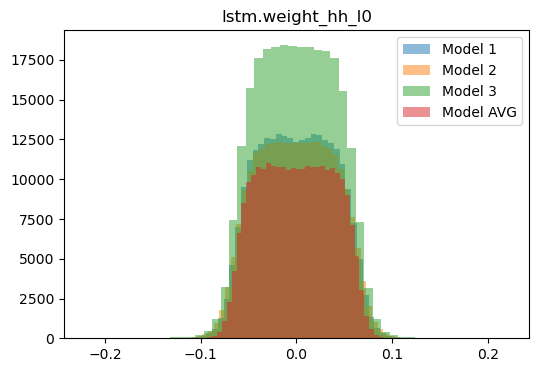

In [19]:
w1 = sd1["lstm.weight_hh_l0"].view(-1).cpu().numpy()  # flatten
w2 = sd2["lstm.weight_hh_l0"].view(-1).cpu().numpy()  # flatten
w3 = sd3["lstm.weight_hh_l0"].view(-1).cpu().numpy() #flatten
w4 = sd_avg["lstm.weight_hh_l0"].view(-1).cpu().numpy() #flatten
plt.figure(figsize=(6, 4))
plt.hist(w1, bins=50, alpha=0.5, label='Model 1')
plt.hist(w2, bins=50, alpha=0.5, label='Model 2')
plt.hist(w3, bins=50, alpha=0.5, label='Model 3')
plt.hist(w4, bins=50, alpha=0.5, label='Model AVG')
plt.legend()
plt.title("lstm.weight_hh_l0")
plt.show()

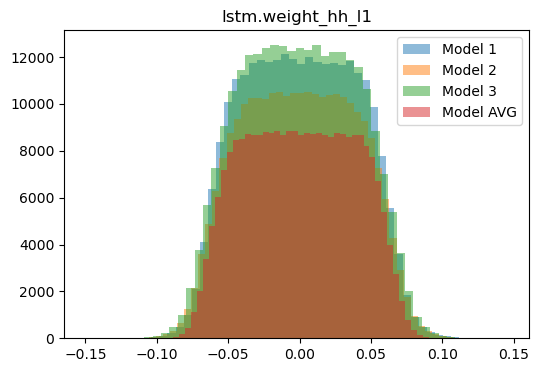

In [20]:
w1 = sd1["lstm.weight_hh_l1"].view(-1).cpu().numpy()  # flatten
w2 = sd2["lstm.weight_hh_l1"].view(-1).cpu().numpy()  # flatten
w3 = sd3["lstm.weight_hh_l1"].view(-1).cpu().numpy() #flatten
w4 = sd_avg["lstm.weight_hh_l1"].view(-1).cpu().numpy() #flatten
plt.figure(figsize=(6, 4))
plt.hist(w1, bins=50, alpha=0.5, label='Model 1')
plt.hist(w2, bins=50, alpha=0.5, label='Model 2')
plt.hist(w3, bins=50, alpha=0.5, label='Model 3')
plt.hist(w4, bins=50, alpha=0.5, label='Model AVG')
plt.legend()
plt.title("lstm.weight_hh_l1")
plt.show()

In [21]:
# Normalize the data (each partition separately)
test_mean4 = (train_mean1 + train_mean2 + train_mean3 + train_mean4)/4
test_std = (train_std1 + train_std2 + train_std3 + train_std4)/4
test_df = fourth_piece
test_df = (test_df - test_mean4)/test_std

In [22]:
test_seq4, test_labels4 = create_sequences(test_df.values, 12)
test_tensor_seq4 = torch.FloatTensor(test_seq4).to(device='cuda')
test_tensor_labels4 = torch.FloatTensor(test_labels4).to(device='cuda')
test_labels_4_un = test_labels4 * fourth_piece.std().values + fourth_piece.mean().values

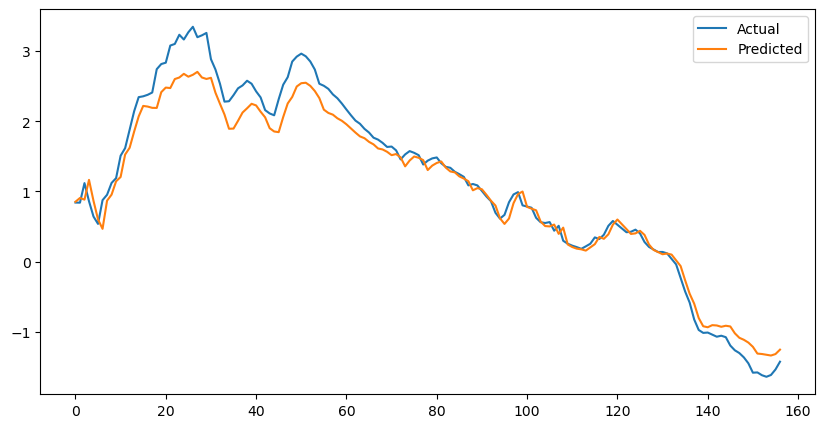

In [23]:
avg_model.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq4)):
        pred = avg_model(test_tensor_seq4[i])
        y_pred.append(pred.item())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

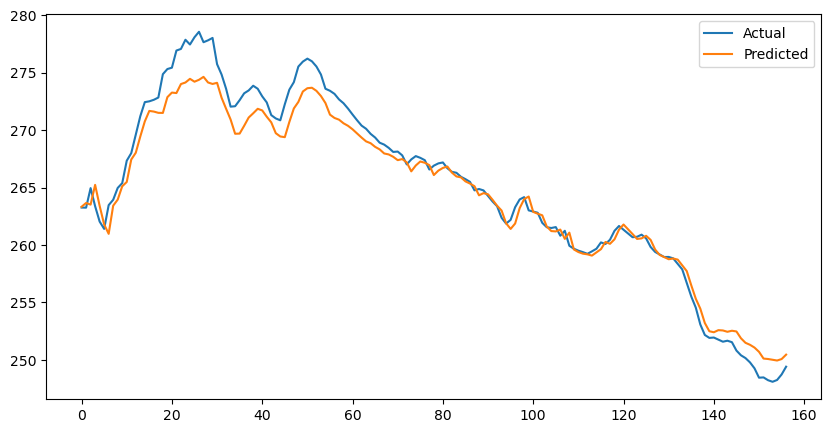

In [24]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * fourth_piece.std().values + fourth_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_4_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [25]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_4_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device='cuda').unsqueeze(1), test_tensor_labels4)}')
# print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device='cuda').unsqueeze(1), train_label_tensor1)}')
criterion1(torch.FloatTensor(y_pred).to(device='cuda'), test_tensor_labels4).item()

MARE_np: 0.004333658270014799
MARE: 0.1508777141571045


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([157, 1])) that is different to the input size (torch.Size([157])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


0.968446671962738

In [26]:
normalized_test_1 = (first_piece[:] - first_piece.mean())/first_piece.std()
test_seq_1, test_labels_1 = create_sequences(normalized_test_1.values, 12)
test_tensor_seq_1 = torch.FloatTensor(test_seq_1).to(device=device)
test_tensor_labels_1 = torch.FloatTensor(test_labels_1).to(device=device)

In [27]:
normalized_test_2 = (second_piece[:] - second_piece.mean())/second_piece.std()
test_seq_2, test_labels_2 = create_sequences(normalized_test_2.values, 12)
test_tensor_seq_2 = torch.FloatTensor(test_seq_2).to(device=device)
test_tensor_labels_2 = torch.FloatTensor(test_labels_2).to(device=device)

In [28]:
normalized_test_3 = (third_piece[:] - third_piece.mean())/third_piece.std()
test_seq_3, test_labels_3 = create_sequences(normalized_test_3.values, 12)
test_tensor_seq_3 = torch.FloatTensor(test_seq_3).to(device='cuda')
test_tensor_labels_3 = torch.FloatTensor(test_labels_3).to(device='cuda')

In [29]:
test_labels_1_un = test_labels_1 * first_piece.std().values + first_piece.mean().values
test_labels_2_un = test_labels_2 * second_piece.std().values + second_piece.mean().values
test_labels_3_un = test_labels_3 * third_piece.std().values + third_piece.mean().values

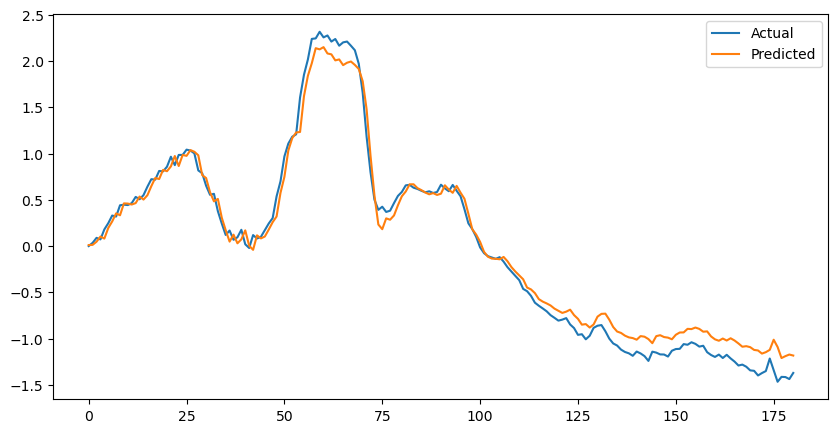

In [30]:
avg_model.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = avg_model(test_tensor_seq_1[i])
        y_pred.append(pred.item())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

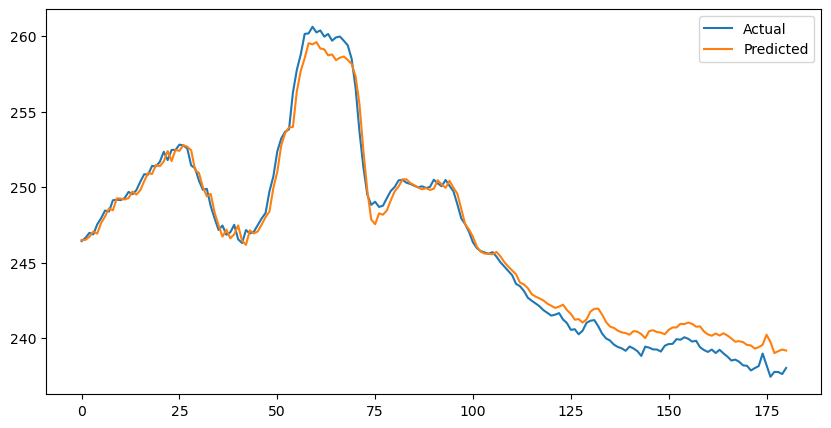

In [31]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * first_piece.std().values + first_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_1_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [32]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_1_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device='cuda').unsqueeze(1), test_tensor_labels_1)}')
# print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device='cuda').unsqueeze(1), train_label_tensor1)}')
criterion1(torch.FloatTensor(y_pred).to(device='cuda'), test_tensor_labels_1).item()

MARE_np: 0.0028904563389499376
MARE: 0.34182825684547424


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([181, 1])) that is different to the input size (torch.Size([181])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


0.7083081007003784

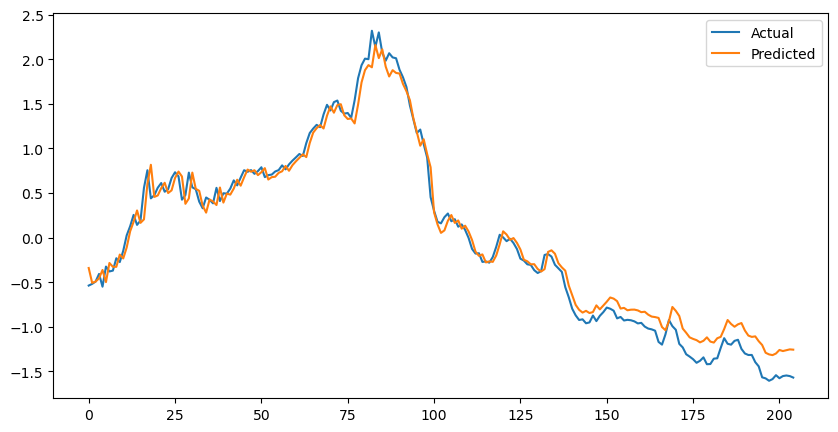

In [33]:
avg_model.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = avg_model(test_tensor_seq_2[i])
        y_pred.append(pred.item())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

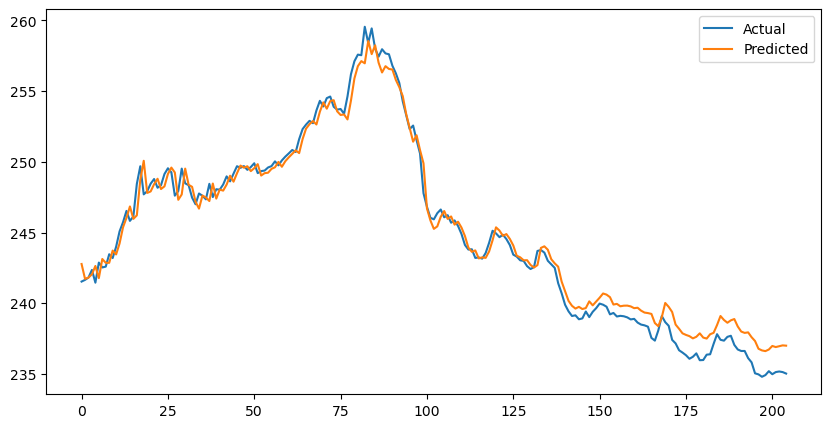

In [34]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * second_piece.std().values + second_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_2_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [35]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_2_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device='cuda').unsqueeze(1), test_tensor_labels_2)}')
# print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device='cuda').unsqueeze(1), train_label_tensor1)}')
criterion1(torch.FloatTensor(y_pred).to(device='cuda'), test_tensor_labels_2).item()

MARE_np: 0.0031552724010475907
MARE: 0.4572600722312927


/home/raman-pc/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:1042: UserWarning: Using a target size (torch.Size([205, 1])) that is different to the input size (torch.Size([205])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


0.7095317244529724

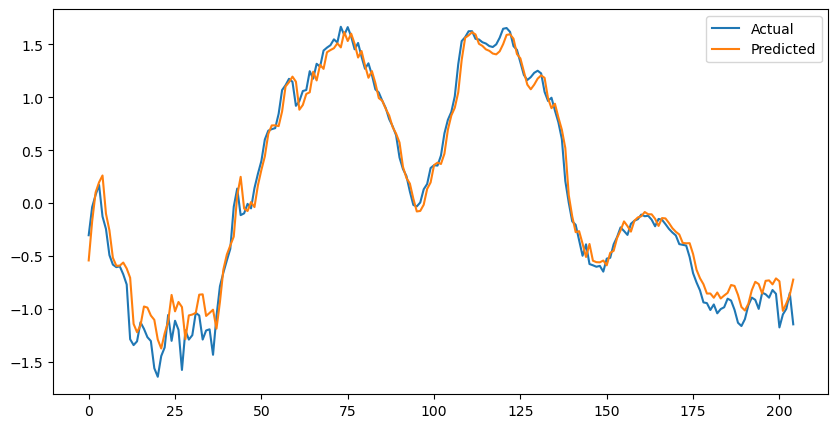

In [36]:
avg_model.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = avg_model(test_tensor_seq_3[i])
        y_pred.append(pred.item())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

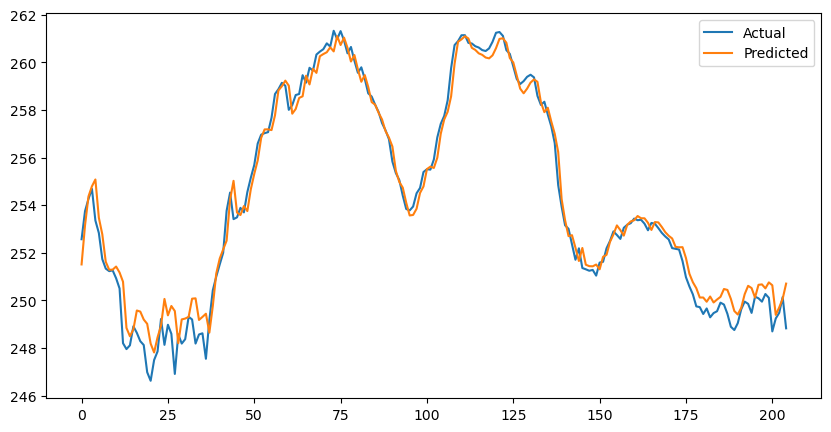

In [37]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * third_piece.std().values + third_piece.mean().values
plt.figure(figsize=(10, 5))
plt.plot(test_labels_3_un, label='Actual')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [38]:
print(f'MARE_np: {MARE_np(y_hat, test_labels_3_un)}')
print(f'MARE: {MARE(torch.FloatTensor(y_pred).to(device='cuda').unsqueeze(1), test_tensor_labels_3)}')
# print(f'MSE: {MSE(torch.FloatTensor(y_pred).to(device='cuda').unsqueeze(1), train_label_tensor1)}')
criterion1(torch.FloatTensor(y_pred).to(device='cuda'), test_tensor_labels_3).item()

MARE_np: 0.0019087306592700452
MARE: 0.45665550231933594


0.6827793121337891